# Deep Convolutional Generative Adversarial Network

In [1]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torchvision.transforms as transforms
from torchvision import datasets
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torch.autograd import Variable

In [3]:
import torch.nn as nn
import torch.nn.functional as F
import torch

## Set Arguments

In [4]:
num_workers = 0
n_epochs = 200
batch_size = 64
lr = 0.0002
b1 = 0.5
b2 = 0.999
n_cpu = 8
latent_dim = 100
img_size = 32
channels = 1
sample_interval = 400

In [5]:
cuda = True if torch.cuda.is_available() else False

## Configure Data Loader

In [6]:
os.makedirs("images/dcgan/", exist_ok=True)

In [7]:
data_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data',
                   train = True,
                   download = True,
                   transform=transforms.Compose(
                       [transforms.Resize(img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]),
                   ),
                   batch_size = batch_size,
                   shuffle = True,
)

## Build DCGAN Architecture

<img src='images/dcgan-architecture.png' width='75%'/>

In [8]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

## Generator

In [9]:
class Generator(nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()
        
        self.init_size = img_size // 4
        self.l1 = nn.Sequential(nn.Linear(latent_dim, 128 * self.init_size ** 2))
        
        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )
        
    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        
        return img

## Discriminator

In [10]:
class Discriminator(nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            *discriminator_block(channels, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = img_size // 2 ** 4
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)

        return validity

#### Initialize the generator and discriminator

In [11]:
generator = Generator()
discriminator = Discriminator()
if cuda:
    generator.cuda()
    discriminator.cuda()

## Loss Function

In [12]:
adversarial_loss = torch.nn.BCELoss()
if cuda: adversarial_loss.cuda()

## Optimizer

In [13]:
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

In [14]:
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

## Training The [Network](https://arxiv.org/pdf/1511.06434)

#### Initialize weights

In [15]:
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

Discriminator(
  (model): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Dropout2d(p=0.25)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Dropout2d(p=0.25)
    (6): BatchNorm2d(32, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): LeakyReLU(negative_slope=0.2, inplace)
    (9): Dropout2d(p=0.25)
    (10): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (11): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (12): LeakyReLU(negative_slope=0.2, inplace)
    (13): Dropout2d(p=0.25)
    (14): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
  )
  (adv_layer): Sequential(
    (0): Linear(in_features=512, out_features=1, bias=True)
    

In [16]:
def imshow(imgs, nrows=5):
    fig = plt.figure(figsize=(20,20))
    for idx in np.arange(25):
        ax = fig.add_subplot(5, 25/nrows, idx+1, xticks=[], yticks=[])
        plt.imshow(imgs[idx, :, :, 0], cmap='gray') # convert from Tensor image
    plt.show()

In [17]:
n_epochs = 200 # theoretically should be high

/anaconda3/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


[Epoch 0/200] [Batch 0/938] [Generator loss: 0.684465] [Discriminator loss: 0.691741]


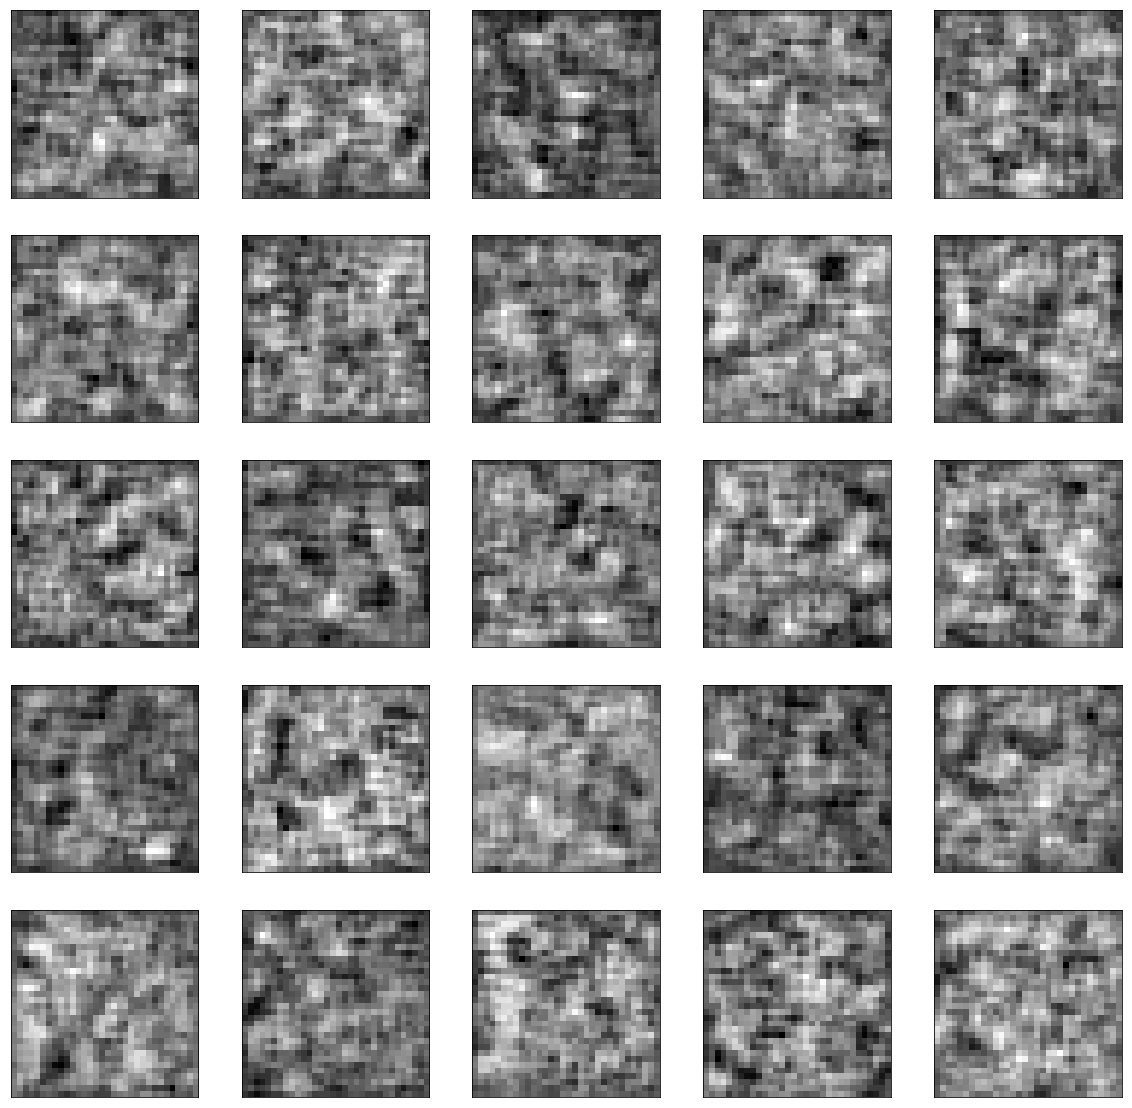

[Epoch 0/200] [Batch 1/938] [Generator loss: 0.684917] [Discriminator loss: 0.689336]
[Epoch 0/200] [Batch 2/938] [Generator loss: 0.685958] [Discriminator loss: 0.686937]
[Epoch 0/200] [Batch 3/938] [Generator loss: 0.686534] [Discriminator loss: 0.684647]
[Epoch 0/200] [Batch 4/938] [Generator loss: 0.687437] [Discriminator loss: 0.682516]
[Epoch 0/200] [Batch 5/938] [Generator loss: 0.687922] [Discriminator loss: 0.680067]
[Epoch 0/200] [Batch 6/938] [Generator loss: 0.688502] [Discriminator loss: 0.674513]
[Epoch 0/200] [Batch 7/938] [Generator loss: 0.689215] [Discriminator loss: 0.673129]
[Epoch 0/200] [Batch 8/938] [Generator loss: 0.690006] [Discriminator loss: 0.669525]
[Epoch 0/200] [Batch 9/938] [Generator loss: 0.689871] [Discriminator loss: 0.666198]
[Epoch 0/200] [Batch 10/938] [Generator loss: 0.689522] [Discriminator loss: 0.660363]
[Epoch 0/200] [Batch 11/938] [Generator loss: 0.690222] [Discriminator loss: 0.658535]
[Epoch 0/200] [Batch 12/938] [Generator loss: 0.6876

KeyboardInterrupt: 

In [18]:
for epoch in range(n_epochs):
    
    g_loss_to_display = []
    d_loss_to_display = []
    for i, (imgs, _) in enumerate(data_loader):
        
        # adversarial ground truths
        valid = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)
        
        # configure input
        real_imgs = Variable(imgs.type(Tensor))
        
        # ----------------
        # Train Generator
        # ----------------
        
        optimizer_G.zero_grad()
        
        # sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))
        
        # generate a batch of images
        gen_imgs = generator(z)
        
        # loss measures the generator's ability to fool the discriminator
        # print(imgs.shape)
        # print(gen_imgs.shape)
        # break
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)
        g_loss_to_display.append(g_loss)
        g_loss.backward()
        
        optimizer_G.step()
        
        # ---------------------
        #  Train Discriminator
        # ---------------------
        
        optimizer_D.zero_grad()
        
        # measure the discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss_to_display.append(d_loss)
        d_loss.backward()
        
        optimizer_D.step()
        
        print(
            "[Epoch %d/%d] [Batch %d/%d] [Generator loss: %f] [Discriminator loss: %f]"
            % (epoch, n_epochs, i, len(data_loader), g_loss.item(), d_loss.item())
        )
        
        batches_done = epoch * len(data_loader) + i
        
        if batches_done % sample_interval == 0:
            gen_imgs_to_display = np.transpose(gen_imgs[:25].cpu().detach(), (0, 2, 3, 1))
            
            # display 25 generated images in one batch and save it
            imshow(gen_imgs_to_display)
            save_image(gen_imgs.data[:25], "images/dcgan/%d.png" % batches_done, nrow=5, normalize=True)

In [ ]:
# plot g_loss and d_loss
plt.figure(figsize=(8,8))
plt.plot(g_loss_to_display, label='Generator Loss')
plt.plot(d_loss_to_display, label='Discriminator Loss')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

<hr/>